<div class="alert alert-block alert-success">

## <center> Tracking Issues created for Repos on GitHub </center>
## <center> Plot and Forecast Issues </center>
    

</div>

<div class="alert alert-block alert-danger">
    
### Deliverables: 
- Submit a single ZIP file  that has the folowing items:
    1. Your PDF document for the analysis report. 
    2. Your IPYNB script with the name GitHub_Repos_Issues_Forecasting.ipynb that has your source code and output for the requirements listed 
    2. Your HTML/PDF document that has your source code and output for the requirements listed 

<br>
    
</div>

<hr style="border:2px solid black"> </hr>
<div class="alert alert-info">



        
## REQUIREMENT 1

Use Python/GitHub API to retrieve Issues/Repos information of the **past 2 months** for the following  repositories:
- https://github.com/meta-llama/llama3
- https://github.com/ollama/ollama
- https://github.com/langchain-ai/langchain
- https://github.com/langchain-ai/langgraph
- https://github.com/microsoft/autogen
- https://github.com/openai/openai-cookbook 
- https://github.com/elastic/elasticsearch 
- https://github.com/milvus-io/pymilvus 


## Important: Data Retrieval Timeframe

 - For **chart visualizations below**, retrieve **past 2 years** of data.
 - For **semantic search and vector embeddings**, use **past 2 months** of data from the above repositories.

    
</div>



In [7]:
!pip install tensorflow
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 42.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 52.9 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import requests
from datetime import datetime, timedelta, timezone
import time

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates

In [11]:
from dotenv import load_dotenv
import os
load_dotenv()

GITHUB_TOKEN = os.environ["GITHUB_TOKEN"]
headers = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}

repos = [
    "meta-llama/llama3",
    "ollama/ollama",
    "langchain-ai/langchain",
    "langchain-ai/langgraph",
    "microsoft/autogen",
    "openai/openai-cookbook",
    "elastic/elasticsearch",
    "milvus-io/pymilvus"
]

now = datetime.today()
since_2_months = (now - timedelta(days=60)).isoformat() + "Z"
since_2_years = (now - timedelta(days=730)).isoformat() + "Z"


In [14]:
def fetch_issues(repo, since, label):
    print(f"Fetching {label} issues from: {repo}")
    all_issues = []
    page = 1
    while True:
        url = f"https://api.github.com/repos/{repo}/issues"
        params = {
            "state": "all",
            "since": since,
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code != 200:
            print(f"Error fetching {repo}: {response.status_code}")
            break
        
        data = response.json()
        if not data:
            break
        for issue in data:
            is_pr = "pull_request" in issue
            all_issues.append({
                "repo": repo,
                "id": issue["id"],
                "number": issue["number"],
                "title": issue["title"],
                "state": issue["state"],
                "created_at": issue["created_at"],
                "closed_at": issue["closed_at"],
                "pull_request": is_pr
            })
        page += 1
        time.sleep(1.5)  # avoid rate limit
    return all_issues

In [15]:
# Retrieve past 2 years of data

issues_2_years = []

for repo in repos:
    issues_2_years += fetch_issues(repo, since_2_years, "2-year")

df_2_years = pd.DataFrame(issues_2_years)
df_2_years.to_csv("data/issues_last_2_years.csv", index=False)

print("==== Done ====")
print(f"Total:{len(df_2_years)}")

Fetching 2-year issues from: meta-llama/llama3
Fetching 2-year issues from: ollama/ollama
Error fetching ollama/ollama: 422
Fetching 2-year issues from: langchain-ai/langchain
Error fetching langchain-ai/langchain: 422
Fetching 2-year issues from: langchain-ai/langgraph
Fetching 2-year issues from: microsoft/autogen
Fetching 2-year issues from: openai/openai-cookbook
Fetching 2-year issues from: elastic/elasticsearch
Error fetching elastic/elasticsearch: 422
Fetching 2-year issues from: milvus-io/pymilvus
==== Done ====
Total:41734


In [16]:
# Retrieve past 2 months of data

issues_2_months = []

for repo in repos:
    issues_2_months += fetch_issues(repo, since_2_months, "2-month")

df_2_months = pd.DataFrame(issues_2_months)
df_2_months.to_csv("data/issues_last_2_months.csv", index=False)

print("==== Done ====")
print(f"Total:{len(df_2_months)}")


Fetching 2-month issues from: meta-llama/llama3
Fetching 2-month issues from: ollama/ollama
Fetching 2-month issues from: langchain-ai/langchain
Fetching 2-month issues from: langchain-ai/langgraph
Fetching 2-month issues from: microsoft/autogen
Fetching 2-month issues from: openai/openai-cookbook
Fetching 2-month issues from: elastic/elasticsearch
Fetching 2-month issues from: milvus-io/pymilvus
==== Done ====
Total:9646


In [17]:
# get commits/branches/contributors/releases for x.7 x.8 x.9 x.10

commits_data = []
branches_data = []
contributors_data = []
releases_data = []

for repo in repos:
    print(f"Processing {repo}...")

    owner, name = repo.split("/")
    
    # get commits
    page = 1
    while True:
        url = f"https://api.github.com/repos/{repo}/commits"
        params = {
            "since": since_2_years,
            "per_page": 100,
            "page": page
        }
        r = requests.get(url, headers=headers, params=params)
        if r.status_code != 200:
            print(f"Error fetching commits for {repo}")
            break
        commits = r.json()
        if not commits:
            break
        for c in commits:
            date = c["commit"]["author"]["date"][:10]  # yyyy-mm-dd
            commits_data.append({"repo": repo, "date": date})
        page += 1
        time.sleep(0.5)

    # get branches
    r = requests.get(f"https://api.github.com/repos/{repo}/branches", headers=headers)
    if r.status_code == 200:
        branches_data.append({
            "repo": repo,
            "branch_count": len(r.json())
        })

    # get contributors
    r = requests.get(f"https://api.github.com/repos/{repo}/contributors", headers=headers)
    if r.status_code == 200:
        contributors_data.append({
            "repo": repo,
            "contributor_count": len(r.json())
        })

    # get releases
    page = 1
    while True:
        url = f"https://api.github.com/repos/{repo}/releases"
        r = requests.get(url, headers=headers, params={"per_page": 100, "page": page})
        if r.status_code != 200:
            print(f"Error fetching releases for {repo}")
            break
        releases = r.json()
        if not releases:
            break
        for rel in releases:
            if rel.get("published_at"):
                releases_data.append({
                    "repo": repo,
                    "date": rel["published_at"][:10]
                })
        page += 1
        time.sleep(1)

df_commits_data = pd.DataFrame(commits_data)
df_branches_data = pd.DataFrame(branches_data)
df_contributors_data = pd.DataFrame(contributors_data)
df_releases_data = pd.DataFrame(releases_data)

df_commits_data.to_csv("data/commits.csv", index=False)
df_branches_data.to_csv("data/branches.csv", index=False)
df_contributors_data.to_csv("data/contributors.csv", index=False)
df_releases_data.to_csv("data/releases.csv", index=False)

print("==== Done ====")

Processing meta-llama/llama3...
Processing ollama/ollama...
Processing langchain-ai/langchain...
Processing langchain-ai/langgraph...
Processing microsoft/autogen...
Processing openai/openai-cookbook...
Processing elastic/elasticsearch...
Processing milvus-io/pymilvus...
==== Done ====


In [69]:
for repo in repos:
    print(f"Processing {repo}...")

    owner, name = repo.split("/")
    # get releases
    page = 1
    total_releases = 0
    while True:
        url = f"https://api.github.com/repos/{repo}/releases"
        r = requests.get(url, headers=headers, params={"per_page": 100, "page": page})
        if r.status_code != 200:
            print(f"Error fetching releases for {repo} (status: {r.status_code})")
            break
        releases = r.json()
        print(f"{repo} - Page {page}: {len(releases)} releases found")
        if not releases:
            break
        for rel in releases:
            if rel.get("published_at"):
                releases_data.append({
                    "repo": repo,
                    "date": rel["published_at"][:10]
                })
                total_releases += 1
        page += 1
        time.sleep(1)


Processing meta-llama/llama3...
meta-llama/llama3 - Page 1: 0 releases found
Processing ollama/ollama...
ollama/ollama - Page 1: 100 releases found
ollama/ollama - Page 2: 23 releases found
ollama/ollama - Page 3: 0 releases found
Processing langchain-ai/langchain...
langchain-ai/langchain - Page 1: 100 releases found
langchain-ai/langchain - Page 2: 100 releases found
langchain-ai/langchain - Page 3: 100 releases found
langchain-ai/langchain - Page 4: 100 releases found
langchain-ai/langchain - Page 5: 100 releases found
langchain-ai/langchain - Page 6: 100 releases found
langchain-ai/langchain - Page 7: 100 releases found
langchain-ai/langchain - Page 8: 100 releases found
langchain-ai/langchain - Page 9: 74 releases found
langchain-ai/langchain - Page 10: 0 releases found
Processing langchain-ai/langgraph...
langchain-ai/langgraph - Page 1: 100 releases found
langchain-ai/langgraph - Page 2: 100 releases found
langchain-ai/langgraph - Page 3: 100 releases found
langchain-ai/langgrap

In [ ]:
# Note:
# meta-llama/llama3: 0 releases found
# openai/openai-cookbook: 0 releases found

In [18]:
# this is  a function to make a strict filter: make sure the data only created in 2 months/yesrs

def filter_recent_issues(df: pd.DataFrame, days: int = 60, mode: str = "created_only") -> pd.DataFrame:
    # format
    df["created_at"] = pd.to_datetime(df["created_at"], utc=True)
    df["closed_at"] = pd.to_datetime(df["closed_at"], utc=True)

    # this is a strict filter
    cutoff_date = datetime.now(timezone.utc) - timedelta(days=days)
    if mode == "created_only":
        df = df[df["created_at"] >= cutoff_date]
    elif mode == "created_or_closed":
        df = df[
            (df["created_at"] >= cutoff_date) |
            (df["closed_at"] >= cutoff_date)
        ]
    else:
        raise ValueError(f"Unsupported mode: {mode}")

    # remove timezone and warning
    df["created_at"] = df["created_at"].dt.tz_localize(None)
    df["closed_at"] = df["closed_at"].dt.tz_localize(None)

    return df

<hr style="border:1px solid black"> </hr>

<div class="alert alert-info">   
    
## REQUIREMENT 2
- A line chart to plot the issues for every repository
    
</div>


/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3445522524.py:9: SettingWithCopyWarning: 
A value is trying to be set on a co

<Figure size 640x480 with 0 Axes>

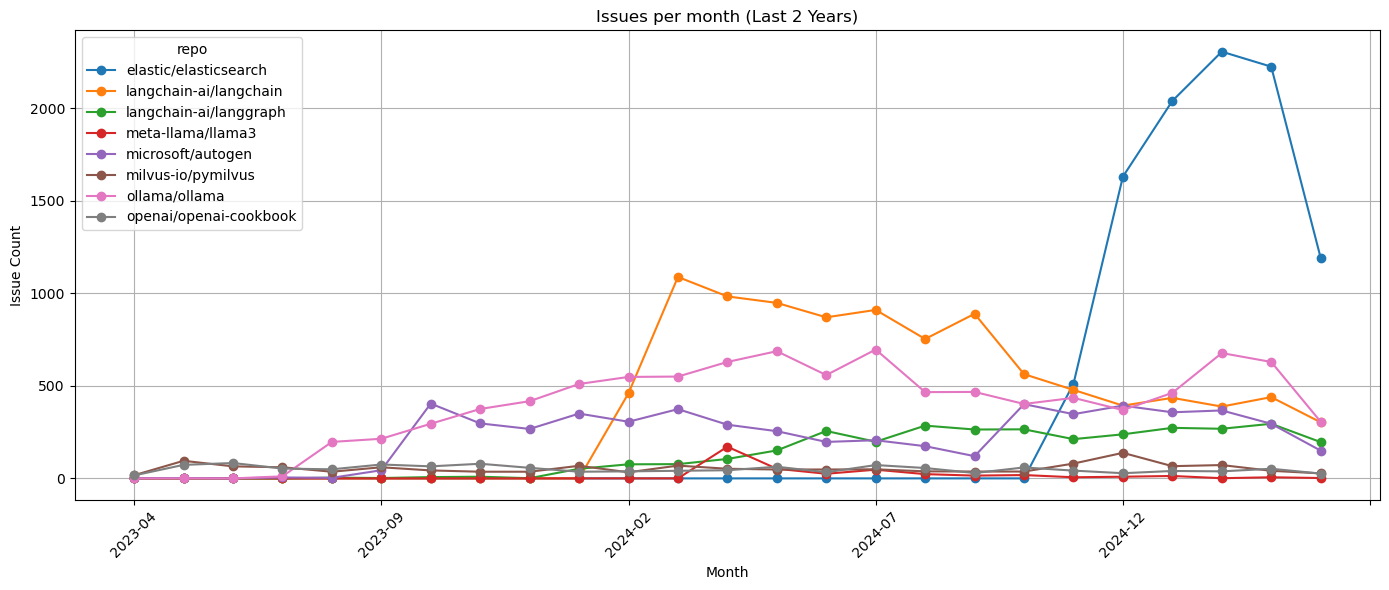

In [19]:
#Add your code for requirement 2 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years
df = filter_recent_issues(df, days=730, mode="created_only")

# group by month
df["month"] = df["created_at"].dt.to_period("M").astype(str)
monthly_df = df.groupby(["repo", "month"]).size().reset_index(name="issue_count")

# pivot a table
pivot_df = monthly_df.pivot(index="month", columns="repo", values="issue_count").fillna(0)

plt.figure()
pivot_df.plot(kind="line", marker="o", figsize=(14, 6))
plt.title("Issues per month (Last 2 Years)")
plt.xlabel("Month")
plt.ylabel("Issue Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../Forecasting/charts/2.line_chart.png")
plt.show()


<hr style="border:1px solid black"> </hr>

<div class="alert alert-info">   
    
## REQUIREMENT 3
- A bar chart to plot the issues created for every month for every repository
    
</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/4132700825.py:9: SettingWithCopyWarning: 
A value is trying to be set on a co

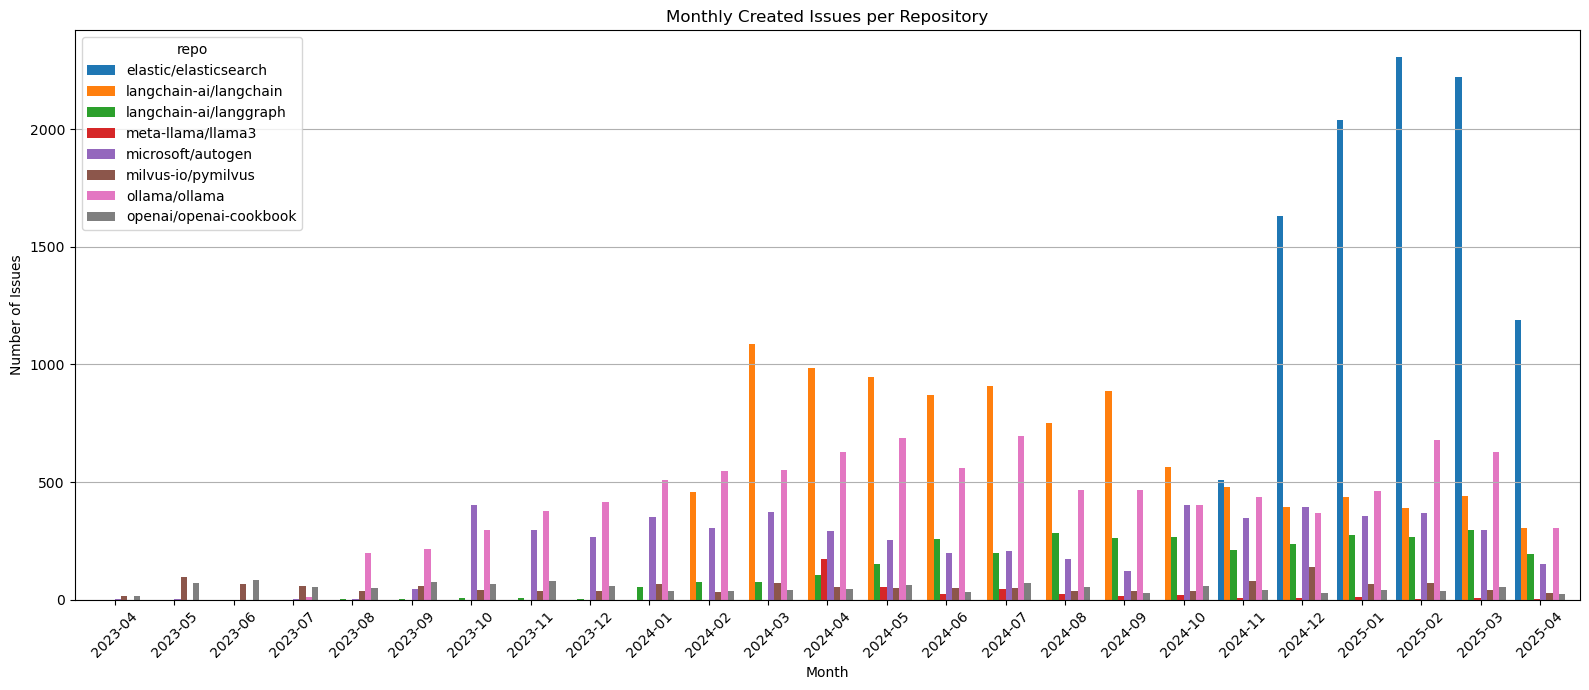

In [20]:
#Add your code for requirement 3 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years
df = filter_recent_issues(df, days=730, mode="created_only")

# group by month
df["month"] = df["created_at"].dt.to_period("M").astype(str)
monthly_df = df.groupby(["repo", "month"]).size().reset_index(name="issue_count")

# pivot a table
pivot_df = monthly_df.pivot(index="month", columns="repo", values="issue_count").fillna(0)

pivot_df.plot(kind="bar", figsize=(16, 7), width=0.85)
plt.title("Monthly Created Issues per Repository")
plt.xlabel("Month")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y")
plt.savefig("../Forecasting/charts/3.monthly_issues.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 4
- A bar chart to plot the starts for every repository
    
</div>

In [21]:
# Fetch Repo Metadata (for stars/forks)
repo_meta = {}
for repo in repos:
    url = f"https://api.github.com/repos/{repo}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        repo_meta[repo] = {
            "stars": data.get("stargazers_count", 0),
            "forks": data.get("forks_count", 0)
        }
    else:
        print(f"Error fetching {repo}: {response.status_code}")
        repo_meta[repo] = {"stars": None, "forks": None}


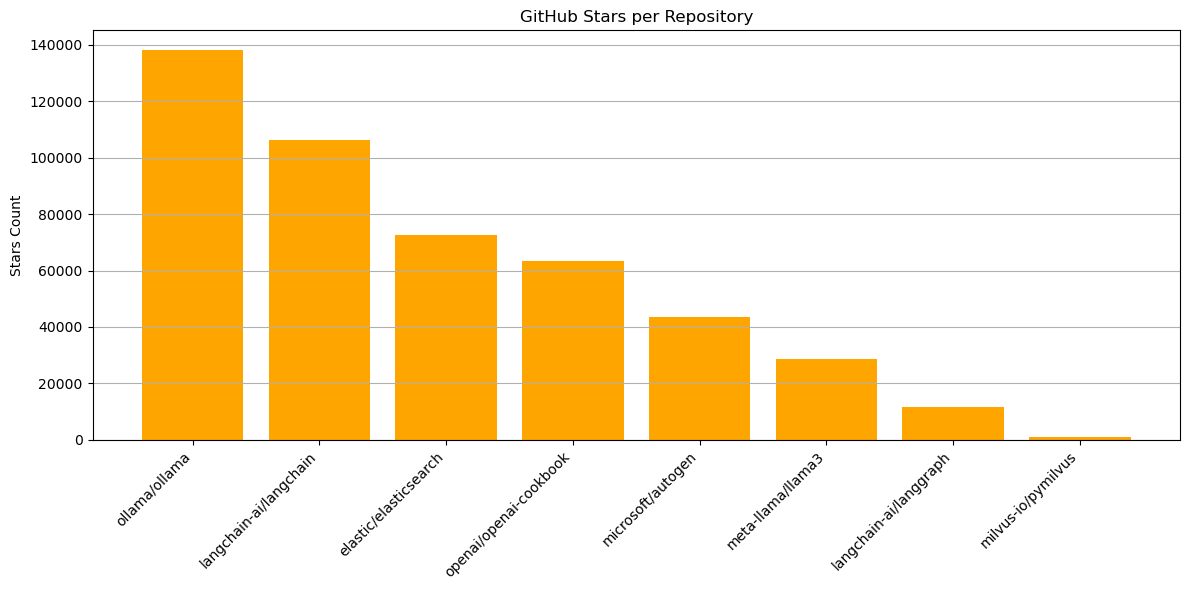

In [22]:
#Add your code for requirement 4 in this cell

# get data
stars_data = {repo: meta["stars"] for repo, meta in repo_meta.items()}

# sort data
sorted_stars = dict(sorted(stars_data.items(
), key=lambda item: item[1] if item[1] is not None else -1, reverse=True))

# bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_stars.keys(), sorted_stars.values(), color="orange")
plt.title("GitHub Stars per Repository")
plt.ylabel("Stars Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../Forecasting/charts/4.repo_stars.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 5
- A bar chart to plot the forks for every repository
    
</div>

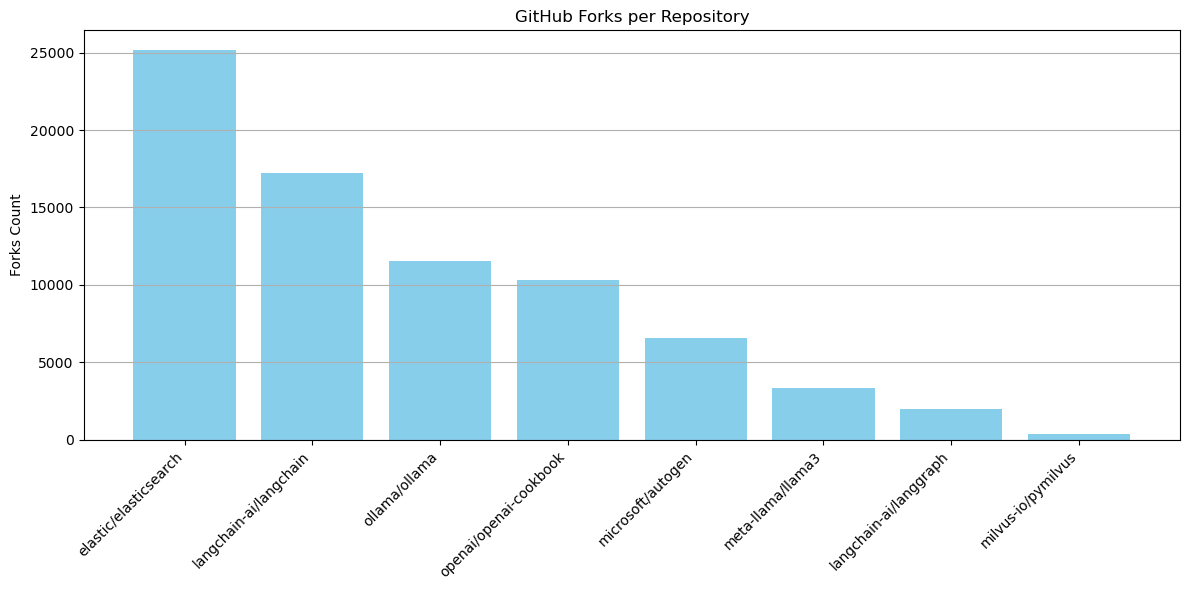

In [24]:
#Add your code for requirement 5 in this cell

# get data
forks_data = {repo: meta["forks"] for repo, meta in repo_meta.items()}

# sort data
sorted_forks = dict(sorted(forks_data.items(
), key=lambda item: item[1] if item[1] is not None else -1, reverse=True))

# bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_forks.keys(), sorted_forks.values(), color="skyblue")
plt.title("GitHub Forks per Repository")
plt.ylabel("Forks Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../Forecasting/charts/5.repo_forks.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 6
- A bar chart to plot the issues closed for every week for every repository
    
</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/4186008699.py:7: SettingWithCopyWarning: 
A value is trying to be set on a co

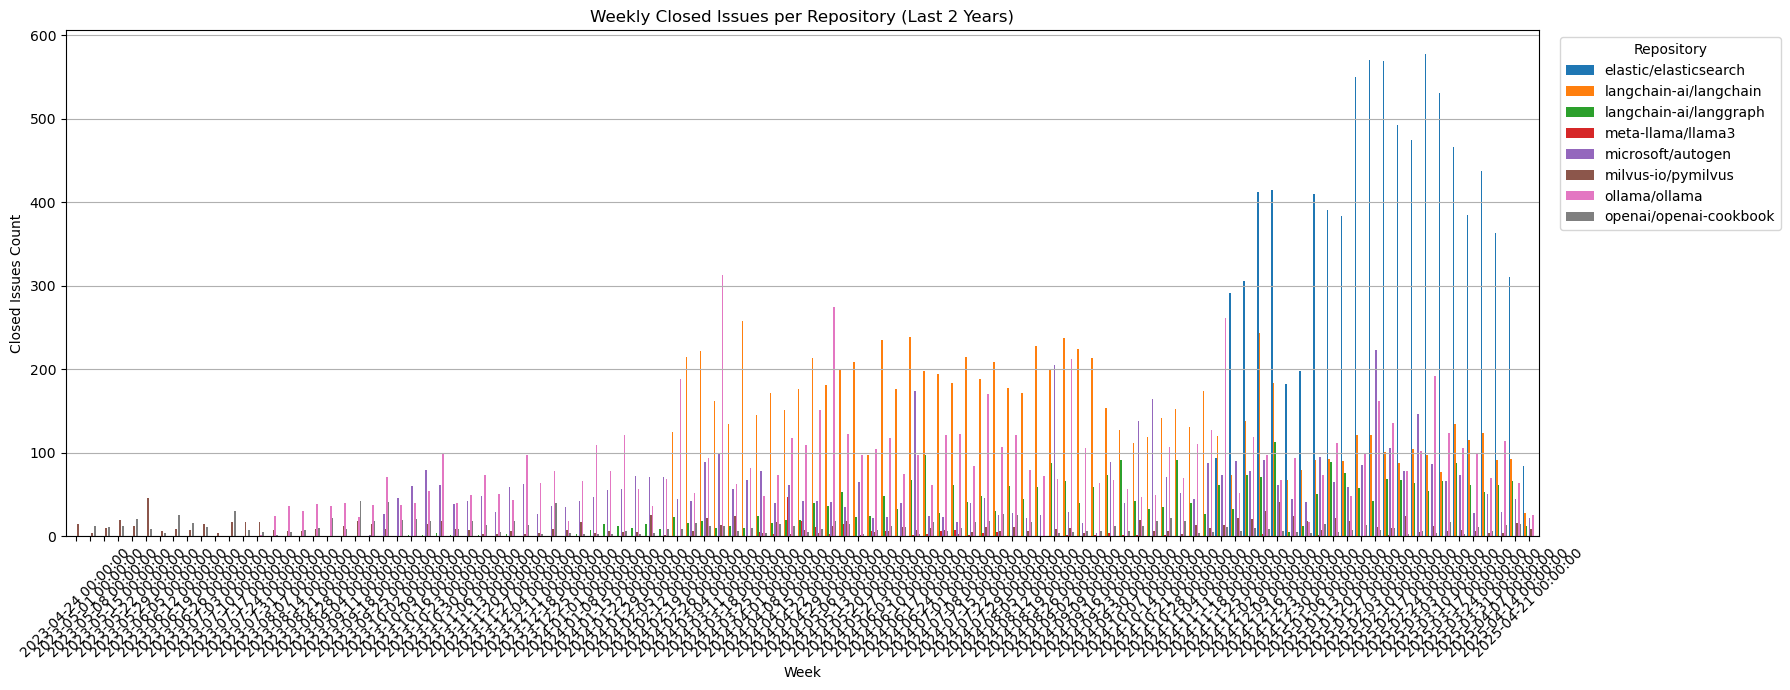

In [25]:
#Add your code for requirement 6 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years
df = filter_recent_issues(df, days=730, mode="created_only")
df["repo"] = df["repo"].astype(str)

# use close at
closed_df = df.dropna(subset=["closed_at"]).copy()

# group by week
closed_df["week"] = closed_df["closed_at"].dt.to_period("W").apply(lambda r: r.start_time)
weekly_closed_df = closed_df.groupby(["week", "repo"]).size().reset_index(name="closed_count")

# pivot a table
pivot_df = weekly_closed_df.pivot(index="week", columns="repo", values="closed_count").fillna(0)

# bar chart
pivot_df.plot(kind="bar", stacked=False, figsize=(18, 7), width=0.9)
plt.title("Weekly Closed Issues per Repository (Last 2 Years)")
plt.xlabel("Week")
plt.ylabel("Closed Issues Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.legend(title="Repository", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../Forecasting/charts/6.weekly_closed_issues.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 7
- A stack-bar Chart to plot the created and closed issues for every repository
    
</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["created_at"] = df["created_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3330455491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["closed_at"] = df["closed_at"].dt.tz_localize(None)
/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/580400226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a cop

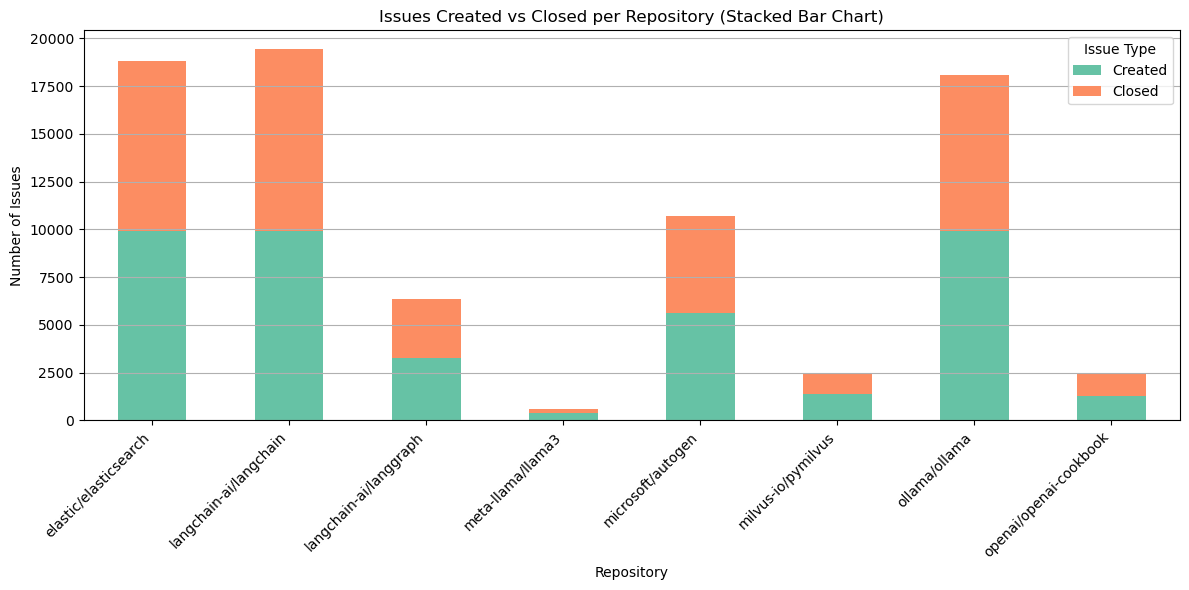

In [26]:
#Add your code for requirement 7 in this cell

# get df and filtering
# df = pd.read_csv("data/issues_last_2_years.csv")
df = df_2_years
df = filter_recent_issues(df, days=730, mode="created_only")
df["repo"] = df["repo"].astype(str)


# get created and closed 
created_counts = df.groupby("repo")["created_at"].count()
closed_counts = df["closed_at"].notna().groupby(df["repo"]).sum()

# merge to one DataFrame
summary_df = pd.DataFrame({
    "Created": created_counts,
    "Closed": closed_counts
})

summary_df.plot(kind="bar", stacked=True, figsize=(12, 6), color=["#66c2a5", "#fc8d62"])
plt.title("Issues Created vs Closed per Repository (Stacked Bar Chart)")
plt.xlabel("Repository")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Issue Type")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("../Forecasting/charts/7.created_vs_closed_stacked.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 8 (TENSORFLOW/KERAS LSTM)
- Use TensorFlow/Keras LSTM package to forecast the following for every repository  
</div>

<div class="alert alert-block alert-success">   
    
#### REQ8-1). The day of the week maximum number of issues created 
    
</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

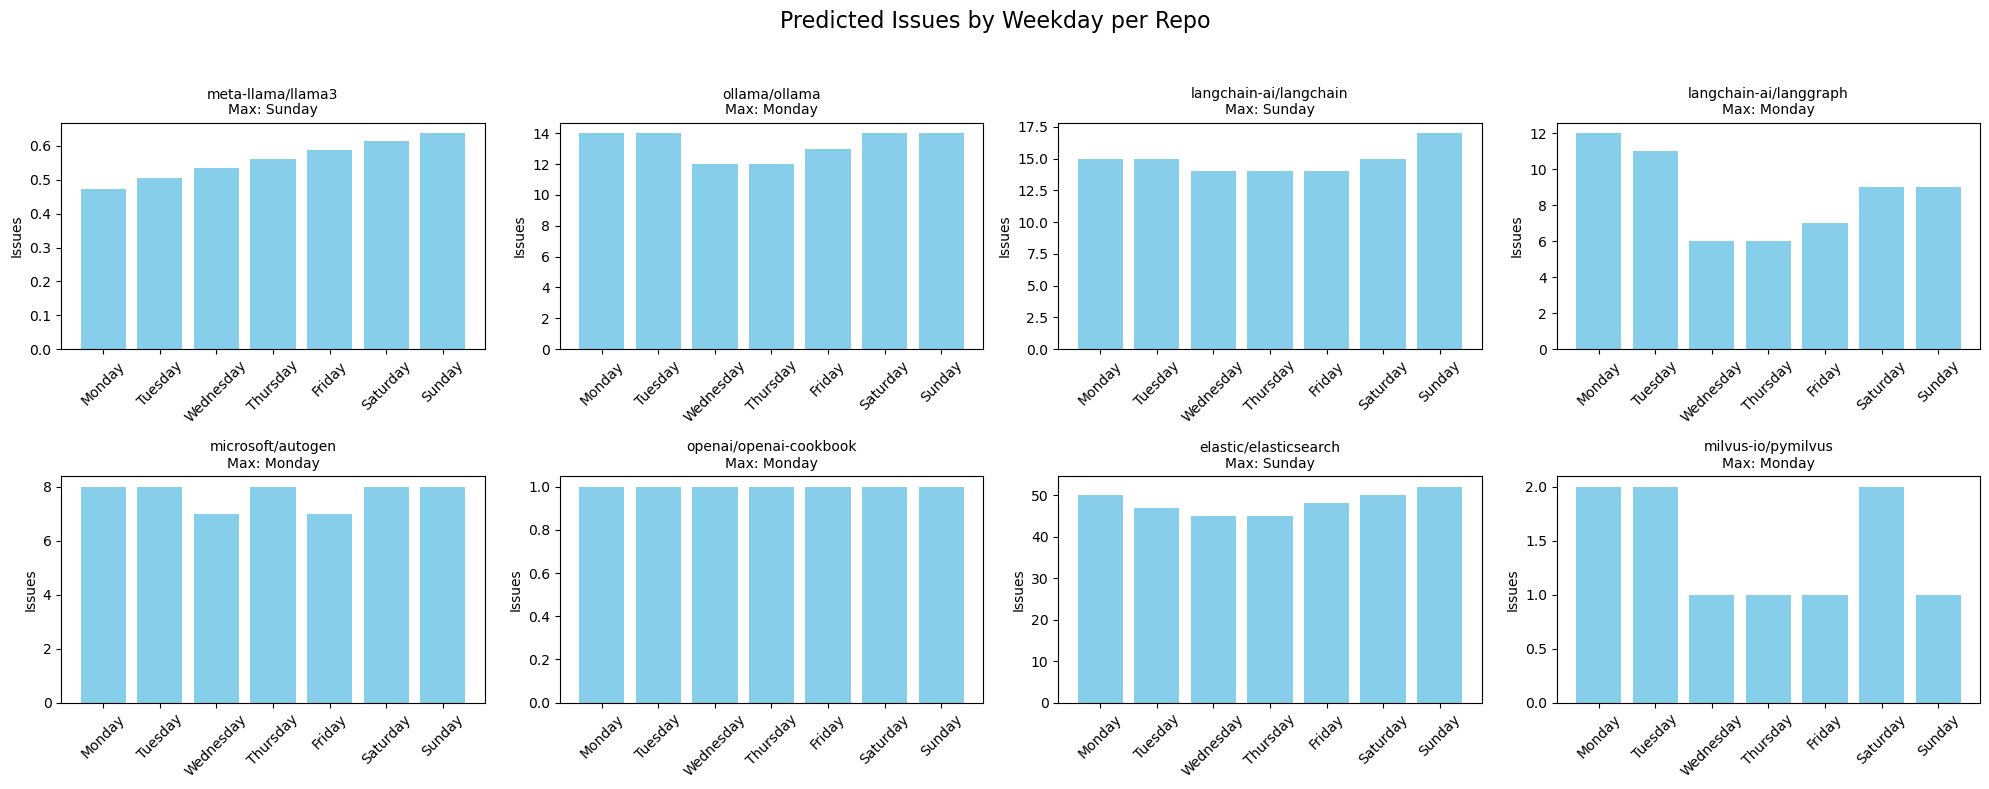

In [27]:
#Add your code for requirement 8.1 in this cell

# get the original df (without filtering)
df = df_2_years
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    repo_df = df[df["repo"] == repo]
    daily_issues = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_issues = daily_issues.reindex(pd.date_range(
        daily_issues.index.min(), daily_issues.index.max()), fill_value=0)
    daily_issues.index.name = "date"

    # normalization
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_issues.values.reshape(-1, 1))

    # prepare LSTM input
    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict next 7 days
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    # inverse transform
    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()
    predictions = np.where(predictions > 1, np.round(
        predictions).astype(int), predictions)
    max_day = days[np.argmax(predictions)]

    # draw subplot
    ax = axs[idx]
    ax.bar(days, predictions, color='skyblue')
    ax.set_title(f"{repo}\nMax: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Issues")

fig.suptitle("Predicted Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title
plt.savefig("../Forecasting/Tensorflow_LSTM/8.1.issues_weekday_prediction_all_repos.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-2). The day of the week maximum number of issues closed 

</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/3906118404.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["repo"] = df["repo"].astype(str)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

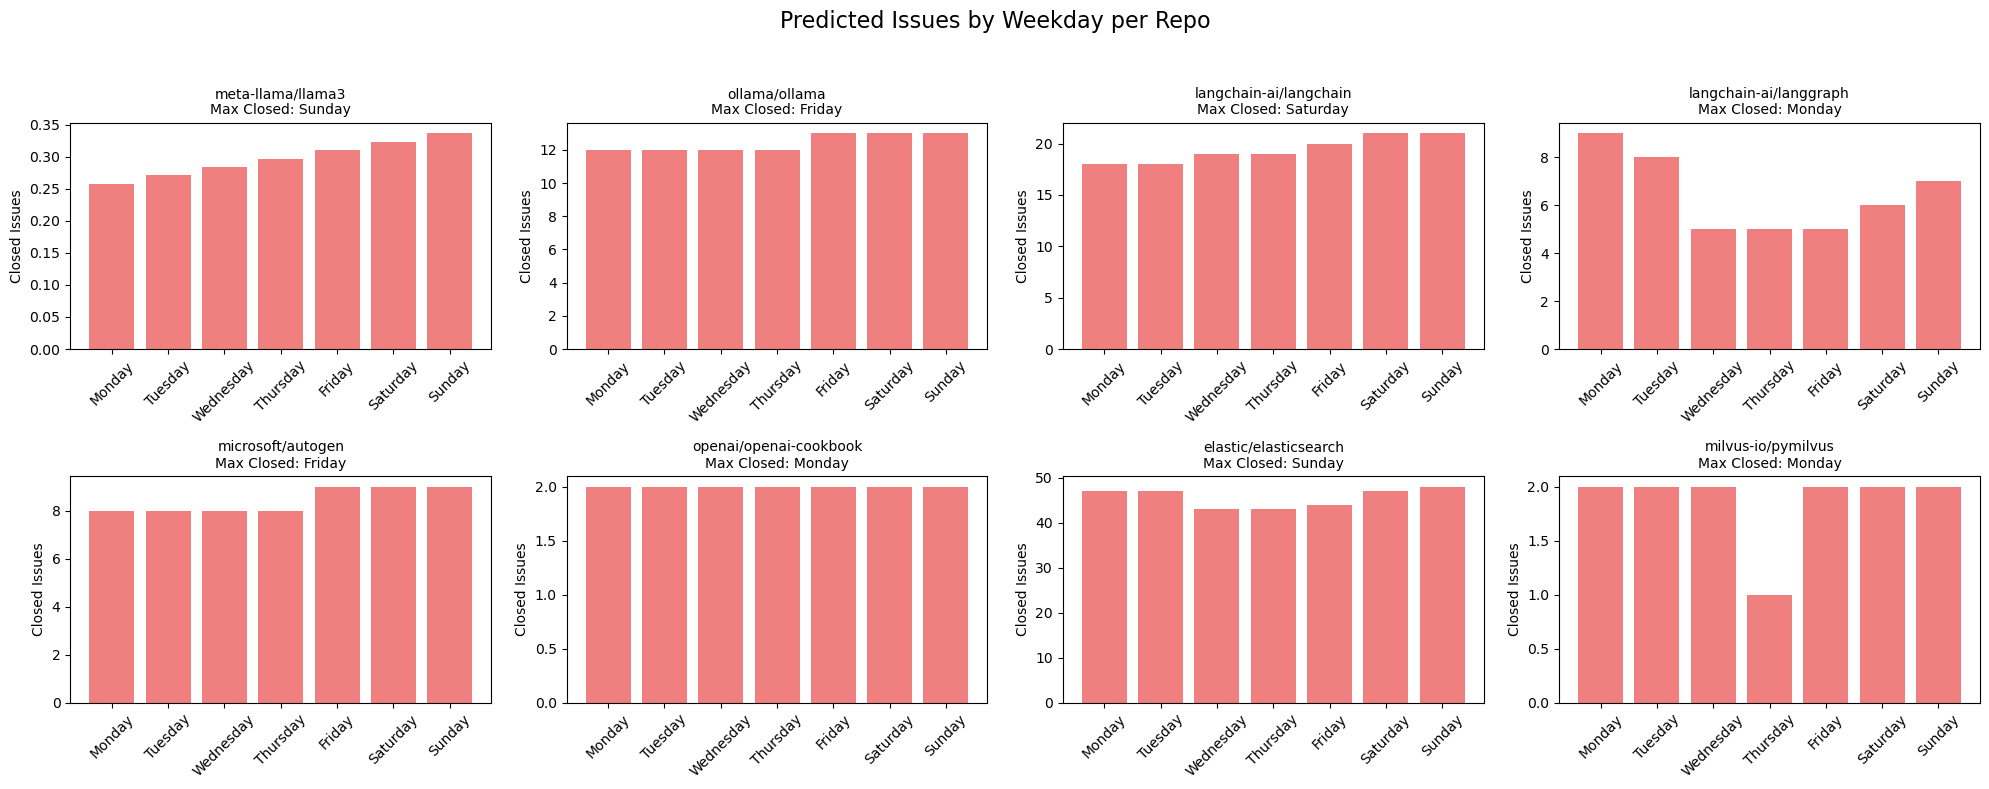

In [28]:
#Add your code for requirement 8.2 in this cell

# get the original df (without filtering)
df = df_2_years
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
days = ["Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo].dropna(subset=["closed_at"])

    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily_closed = daily_closed.reindex(pd.date_range(
        daily_closed.index.min(), daily_closed.index.max()), fill_value=0)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_closed.values.reshape(-1, 1))

    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # next week
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()
    predictions = np.where(predictions > 1, np.round(
        predictions).astype(int), predictions)
    max_day = days[np.argmax(predictions)]

    ax.bar(days, predictions, color='lightcoral')
    ax.set_title(f"{repo}\nMax Closed: {max_day}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")

fig.suptitle("Predicted Issues by Weekday per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for title
plt.savefig("../Forecasting/Tensorflow_LSTM/8.2.issues_closed_weekday_prediction_all_repos.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-3). The month of the year that has maximum number of issues closed 


</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/2318327661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["repo"] = df["repo"].astype(str)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

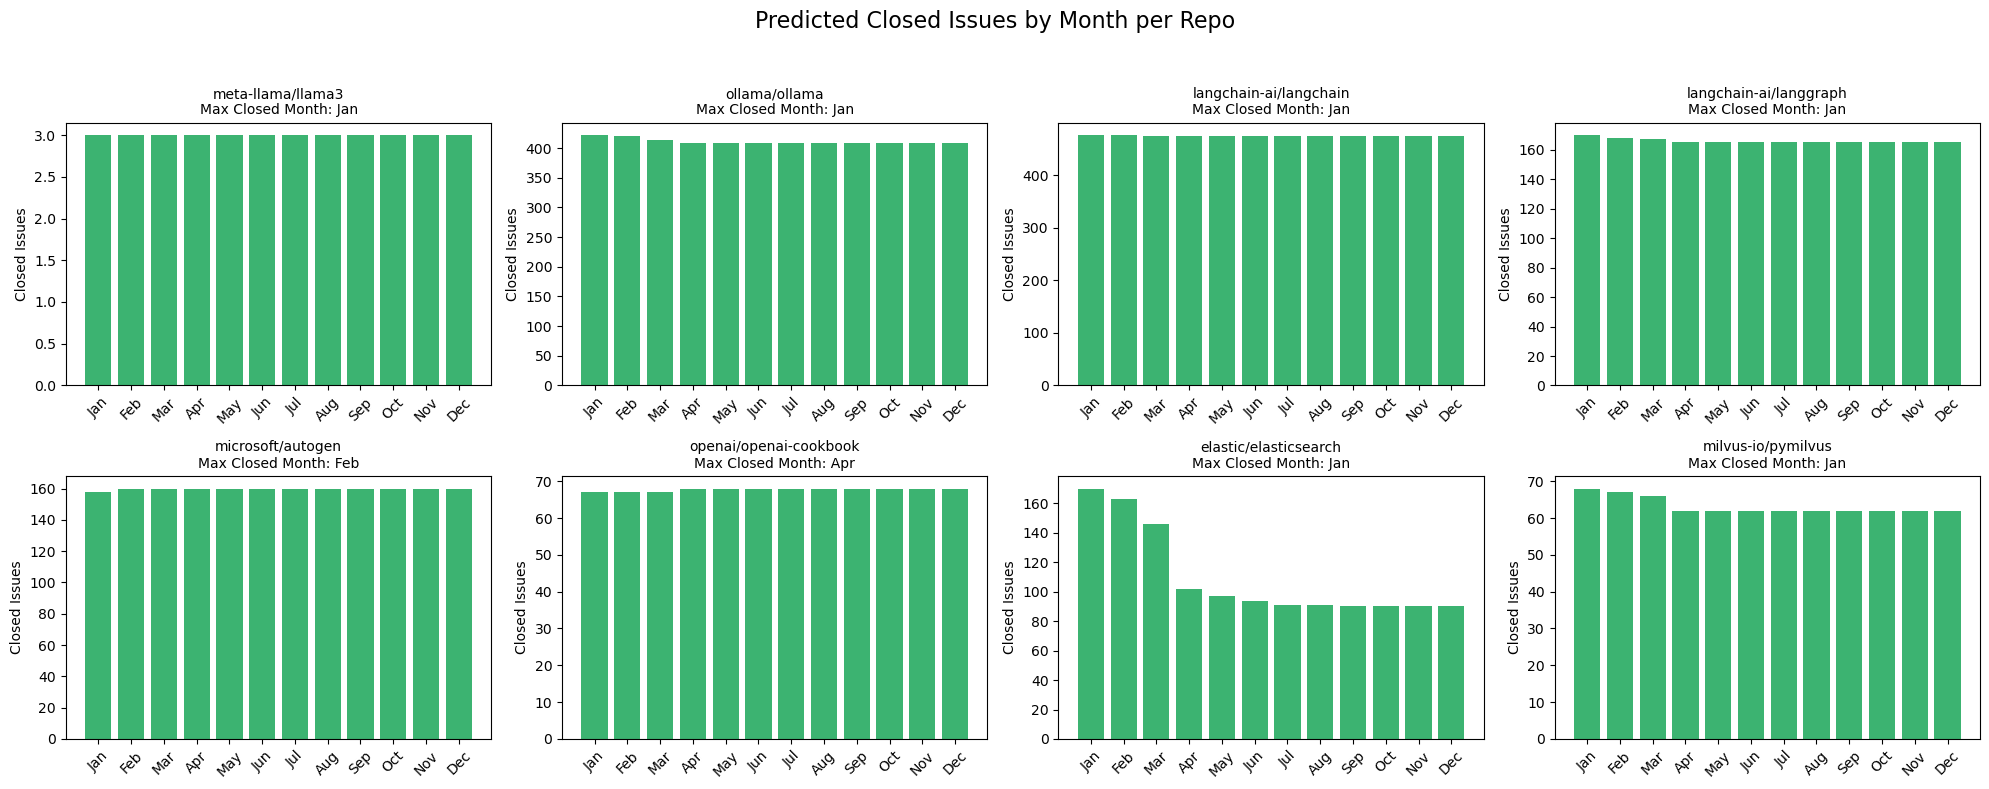

In [29]:
#Add your code for requirement 8.3 in this cell

# get the original df (without filtering)
df = df_2_years
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo].dropna(subset=["closed_at"])

    # group by month
    repo_df["month"] = repo_df["closed_at"].dt.month
    monthly_counts = repo_df.groupby("month").size()
    monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(monthly_counts.values.reshape(-1, 1))

    X, y = [], []
    # use every 3 months to predict
    lookback = 3
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict next 12 months
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(12):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()
    predictions = np.where(predictions > 1, np.round(
        predictions).astype(int), predictions)
    max_month = months[np.argmax(predictions)]

    ax.bar(months, predictions, color='mediumseagreen')
    ax.set_title(f"{repo}\nMax Closed Month: {max_month}", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Closed Issues")

fig.suptitle("Predicted Closed Issues by Month per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.3.issues_closed_month_prediction_all_repos.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-4). Plot the created issues forecast 

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

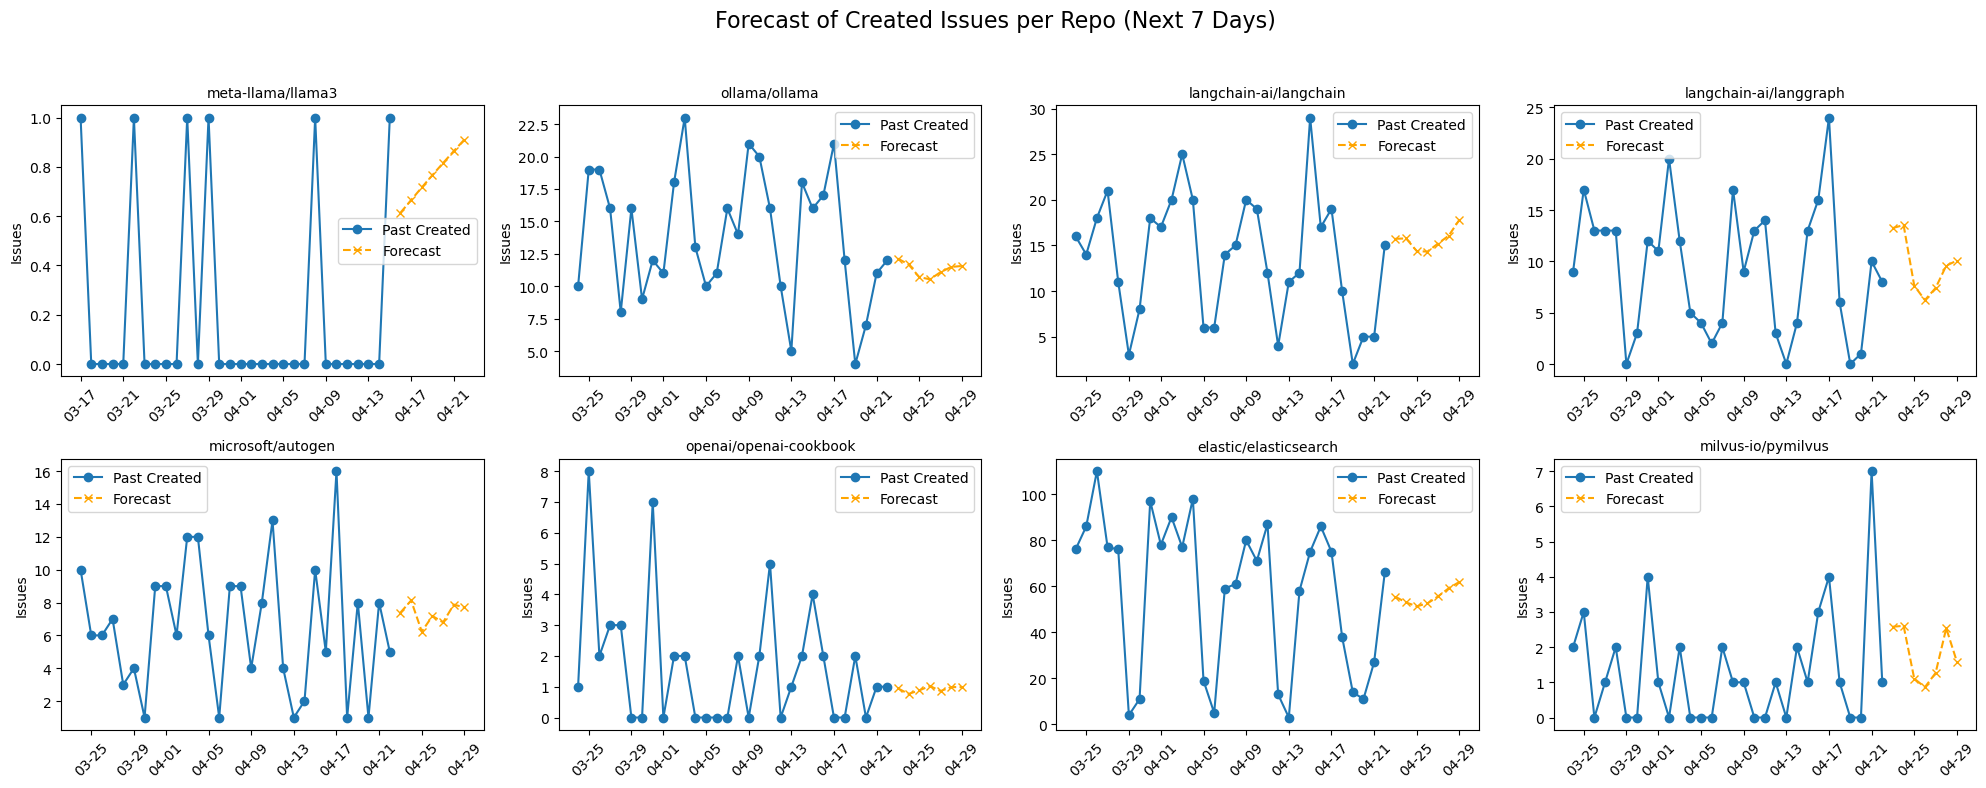

In [31]:
#Add your code for requirement 8.4 in this cell

# get the original df (without filtering)
df = df_2_years
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo]

    if repo_df.empty:
        ax.text(0.5, 0.5, "No enough data in 2 months", fontsize=12,
                ha='center', va='center', color='gray')
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    daily_created = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_created = daily_created.reindex(pd.date_range(
        daily_created.index.min(), daily_created.index.max()), fill_value=0)
    daily_created.index.name = "date"

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_created.values.reshape(-1, 1))

    # input
    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    # predict next 7 days
    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()

    # plot: real + forecast
    past_dates = daily_created.index[-30:]
    past_values = daily_created.values[-30:]
    future_dates = pd.date_range(
        past_dates[-1] + pd.Timedelta(days=1), periods=7)

    ax.plot(past_dates, past_values, label="Past Created", marker='o')
    ax.plot(future_dates, predictions, label="Forecast",
            linestyle="--", marker='x', color='orange')
    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Issues")
    ax.legend()

fig.suptitle(
    "Forecast of Created Issues per Repo (Next 7 Days)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.4.created_issues_forecast_per_repo.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-5). Plot the closed issues forecast 

</div>

/var/folders/9r/wvblfhlx2pj_5fnn4rvs6j0r0000gn/T/ipykernel_77048/2589060082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["repo"] = df["repo"].astype(str)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

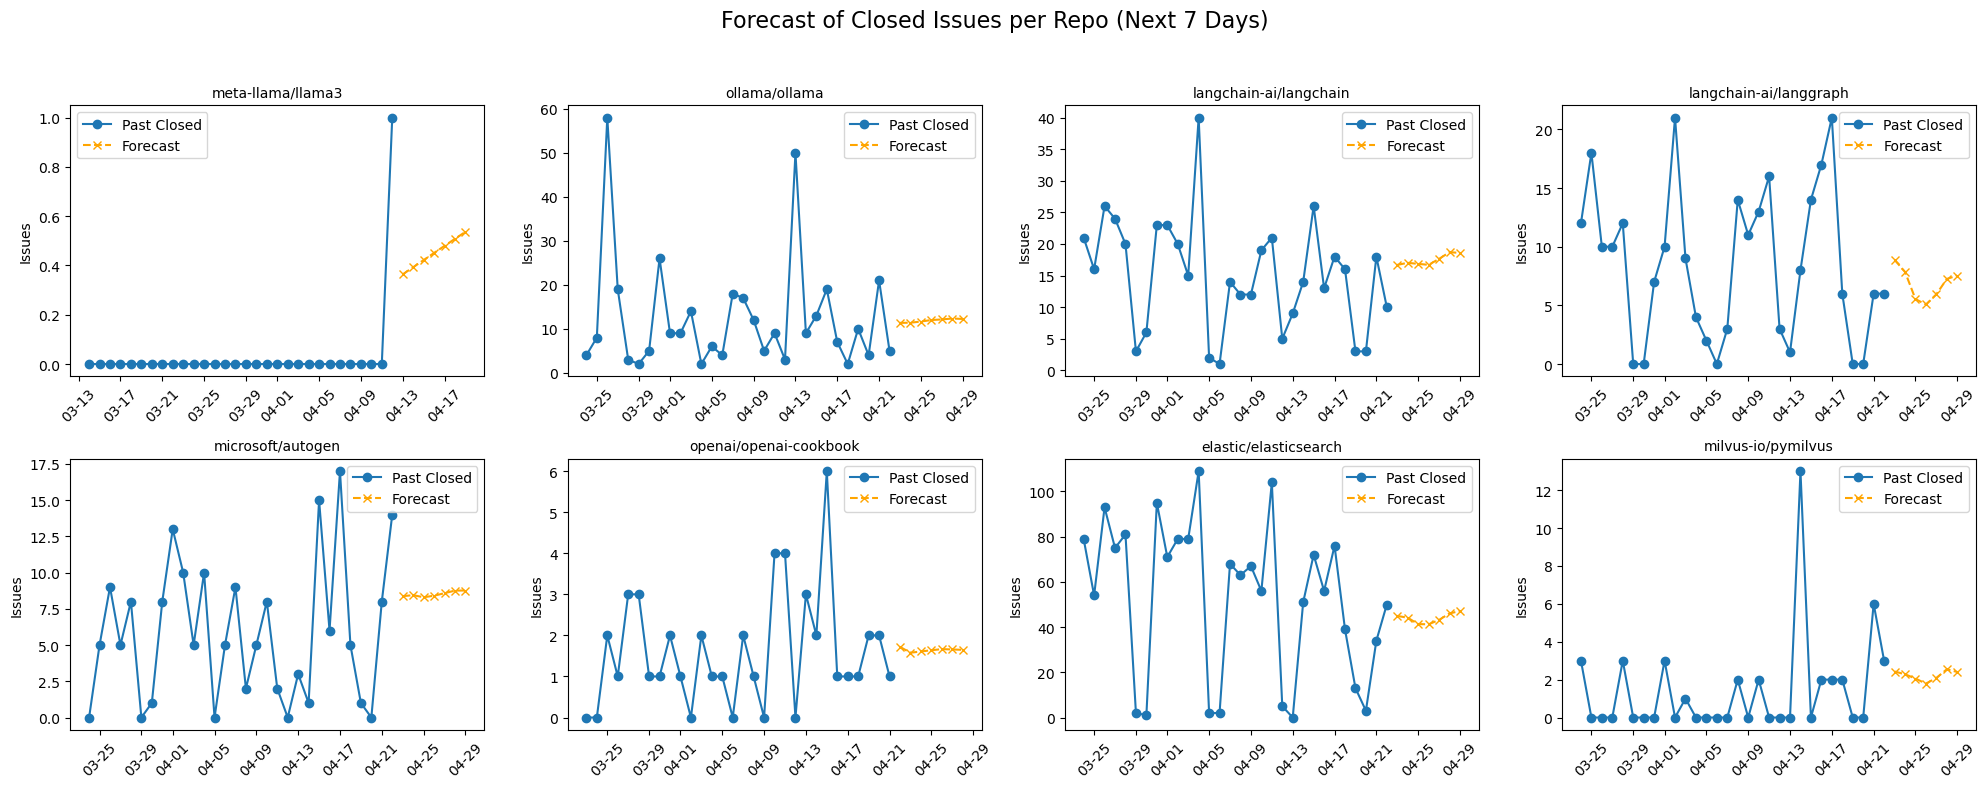

In [32]:
#Add your code for requirement 8.5 in this cell

# get the original df (without filtering)
df = df_2_years
df["closed_at"] = pd.to_datetime(df["closed_at"])
df = df[df["closed_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

repo_names = df["repo"].unique()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[df["repo"] == repo].dropna(subset=["closed_at"])

    if repo_df.empty:
        ax.text(0.5, 0.5, "No enough data in 2 months", fontsize=12,
                ha='center', va='center', color='gray')
        ax.set_title(f"{repo}", fontsize=10)
        ax.axis("off")
        continue

    daily_closed = repo_df.groupby(repo_df["closed_at"].dt.date).size()
    daily_closed = daily_closed.reindex(pd.date_range(
        daily_closed.index.min(), daily_closed.index.max()), fill_value=0)
    daily_closed.index.name = "date"

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_closed.values.reshape(-1, 1))

    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(
            current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1)).flatten()

    past_dates = daily_closed.index[-30:]
    past_values = daily_closed.values[-30:]
    future_dates = pd.date_range(
        past_dates[-1] + pd.Timedelta(days=1), periods=7)

    ax.plot(past_dates, past_values, label="Past Closed", marker='o')
    ax.plot(future_dates, predictions, label="Forecast",
            linestyle="--", marker='x', color='orange')
    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Issues")
    ax.legend()

fig.suptitle(
    "Forecast of Closed Issues per Repo (Next 7 Days)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.5.closed_issues_forecast_per_repo.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-6). Plot the pulls forecast 

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

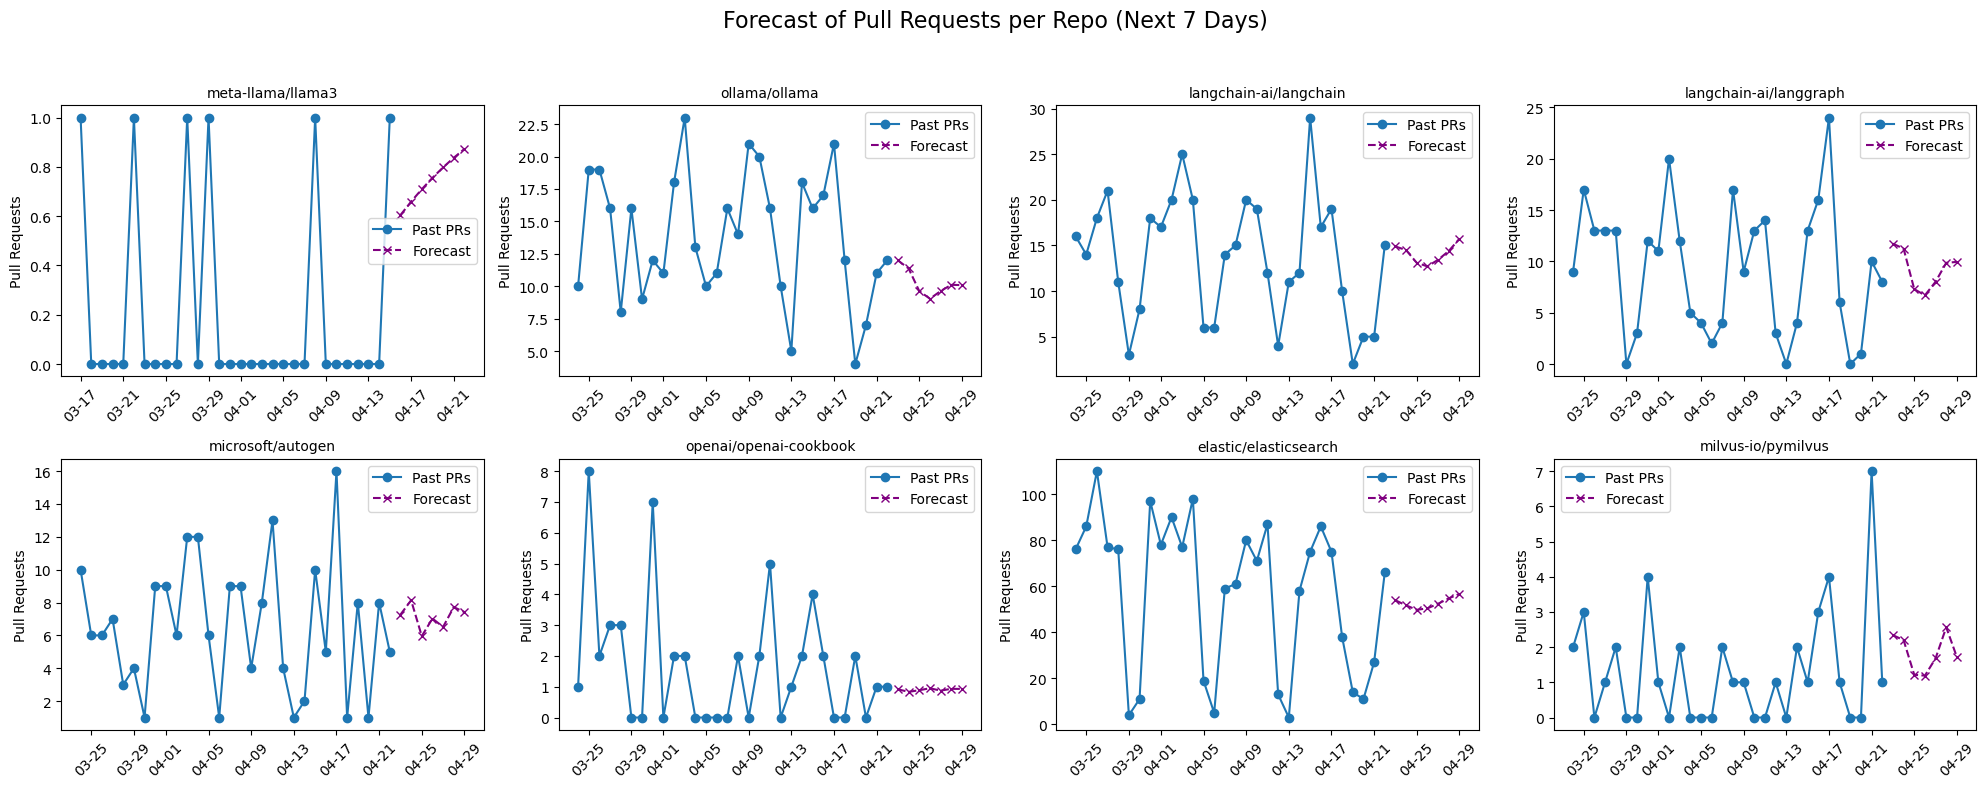

In [33]:
#Add your code for requirement 8.6 in this cell

# get the original df (without filtering)
df = df_2_years
df["created_at"] = pd.to_datetime(df["created_at"])
df = df[df["created_at"].notna()]
df["repo"] = df["repo"].astype(str)

# make it 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# 2D to 1D array (for loop)
axs = axs.flatten()

if "pull_request" not in df.columns:
    print("No 'pull_request' column")
    df["is_pr"] = False
else:
    df["is_pr"] = df["pull_request"].notna()

# get df_pr
df_pr = df[df["is_pr"]]

repo_names = df_pr["repo"].unique()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df[(df["repo"] == repo) & (df["pull_request"].notna())]

    daily_prs = repo_df.groupby(repo_df["created_at"].dt.date).size()
    daily_prs = daily_prs.reindex(pd.date_range(
        daily_prs.index.min(), daily_prs.index.max()), fill_value=0)
    daily_prs.index.name = "date"

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(daily_prs.values.reshape(-1, 1))

    X, y = [], []
    lookback = 7
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=10, verbose=0)

    input_seq = scaled[-lookback:]
    predictions = []
    current_input = input_seq.reshape(1, lookback, 1)

    for _ in range(7):
        pred = model.predict(current_input, verbose=0)[0][0]
        predictions.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    past_dates = daily_prs.index[-30:]
    past_values = daily_prs.values[-30:]
    future_dates = pd.date_range(past_dates[-1] + pd.Timedelta(days=1), periods=7)

    ax.plot(past_dates, past_values, label="Past PRs", marker='o')
    ax.plot(future_dates, predictions, label="Forecast", linestyle="--", marker='x', color='purple')
    ax.set_title(f"{repo}", fontsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Pull Requests")
    ax.legend()

fig.suptitle("Forecast of Pull Requests per Repo (Next 7 Days)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.6.pull_requests_forecast_per_repo.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-7). Plot the commits forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

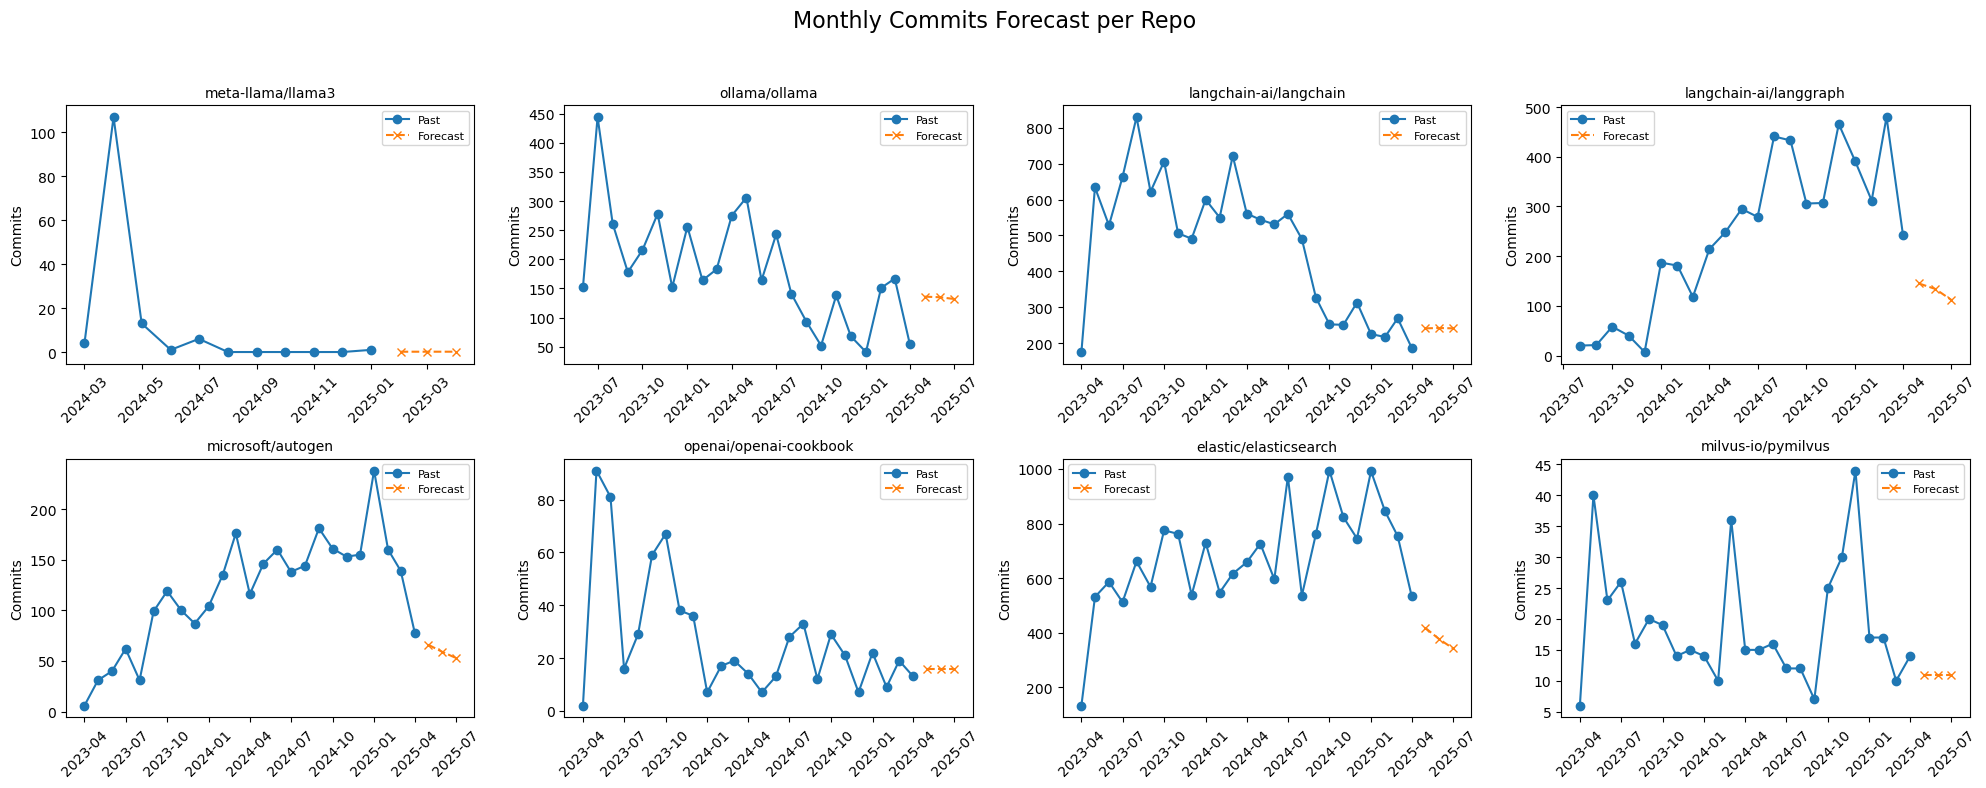

In [35]:
# df_commits_data = pd.read_csv("commits.csv")
df_commits_data["date"] = pd.to_datetime(df_commits_data["date"])

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_commits_data[df_commits_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    monthly_commits = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly_commits.index = monthly_commits.index.to_timestamp()  # convert Period to Timestamp

    if monthly_commits.empty or pd.isna(monthly_commits.index.min()) or pd.isna(monthly_commits.index.max()):
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # fill missing months
    full_index = pd.date_range(monthly_commits.index.min(), monthly_commits.index.max(), freq="MS")
    monthly_commits = monthly_commits.reindex(full_index, fill_value=0)

    # forecast
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(monthly_commits.values.reshape(-1, 1))

    lookback = 3
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, verbose=0)

    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    
    # 3 months forecast
    for _ in range(3):  
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    preds = np.where(preds > 1, np.round(preds).astype(int), preds)

    # draw
    ax.plot(monthly_commits.index, monthly_commits.values, label="Past", marker='o')
    future_dates = pd.date_range(monthly_commits.index[-1] + pd.DateOffset(months=1), periods=3, freq="MS")
    ax.plot(future_dates, preds, label="Forecast", linestyle='--', marker='x')
    ax.set_title(repo, fontsize=10)
    ax.set_ylabel("Commits")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)

fig.suptitle("Monthly Commits Forecast per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.7.monthly_commits_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-8). Plot the branches forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

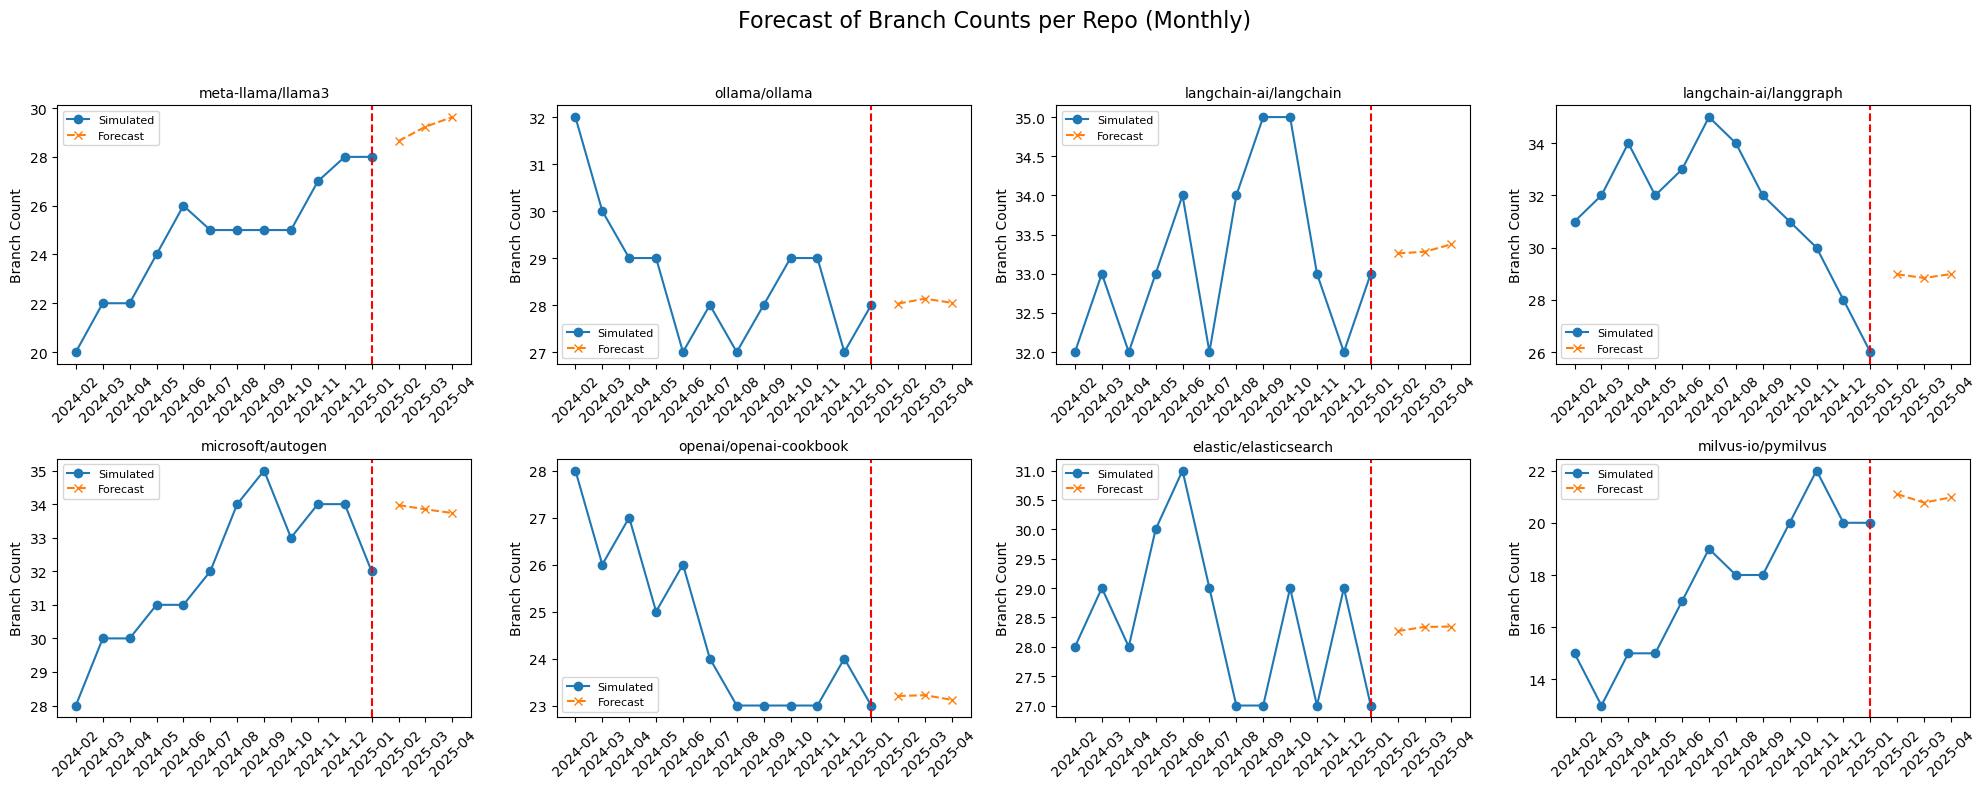

In [ ]:
# Add your code for requirement 8.8 in this cell

# Note: GitHub does not provide branch statistics over time with dates. 
# The /branches API only returns a current total count.
# To generate a time series suitable for forecasting,
# I simulate monthly branch counts using the latest known value and add random noise. 
# This lets me train an LSTM model and predict the next 3 months.

repos = df_branches_data["repo"].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_branches_data[df_branches_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate a historical monthly series using current value and noise.
    latest = row["branch_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-2, 3, size=12).cumsum(), 0, None)

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(simulated_series.reshape(-1, 1))

    # LSTM data
    lookback = 3
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # next 3 months
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(3):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    all_values = np.concatenate([simulated_series, preds])

    
    months = pd.date_range(end=pd.Timestamp.today(), periods=len(all_values), freq="MS").strftime("%Y-%m")
    ax.plot(months[:len(simulated_series)], simulated_series, label="Simulated", marker="o")
    ax.plot(months[len(simulated_series):], preds, label="Forecast", marker="x", linestyle="--")
    ax.axvline(x=months[len(simulated_series)-1], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Branch Count")
    ax.legend(fontsize=8)


fig.suptitle("Forecast of Branch Counts per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.8.monthly_branches_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-9). Plot the contributors forecast

</div>

/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

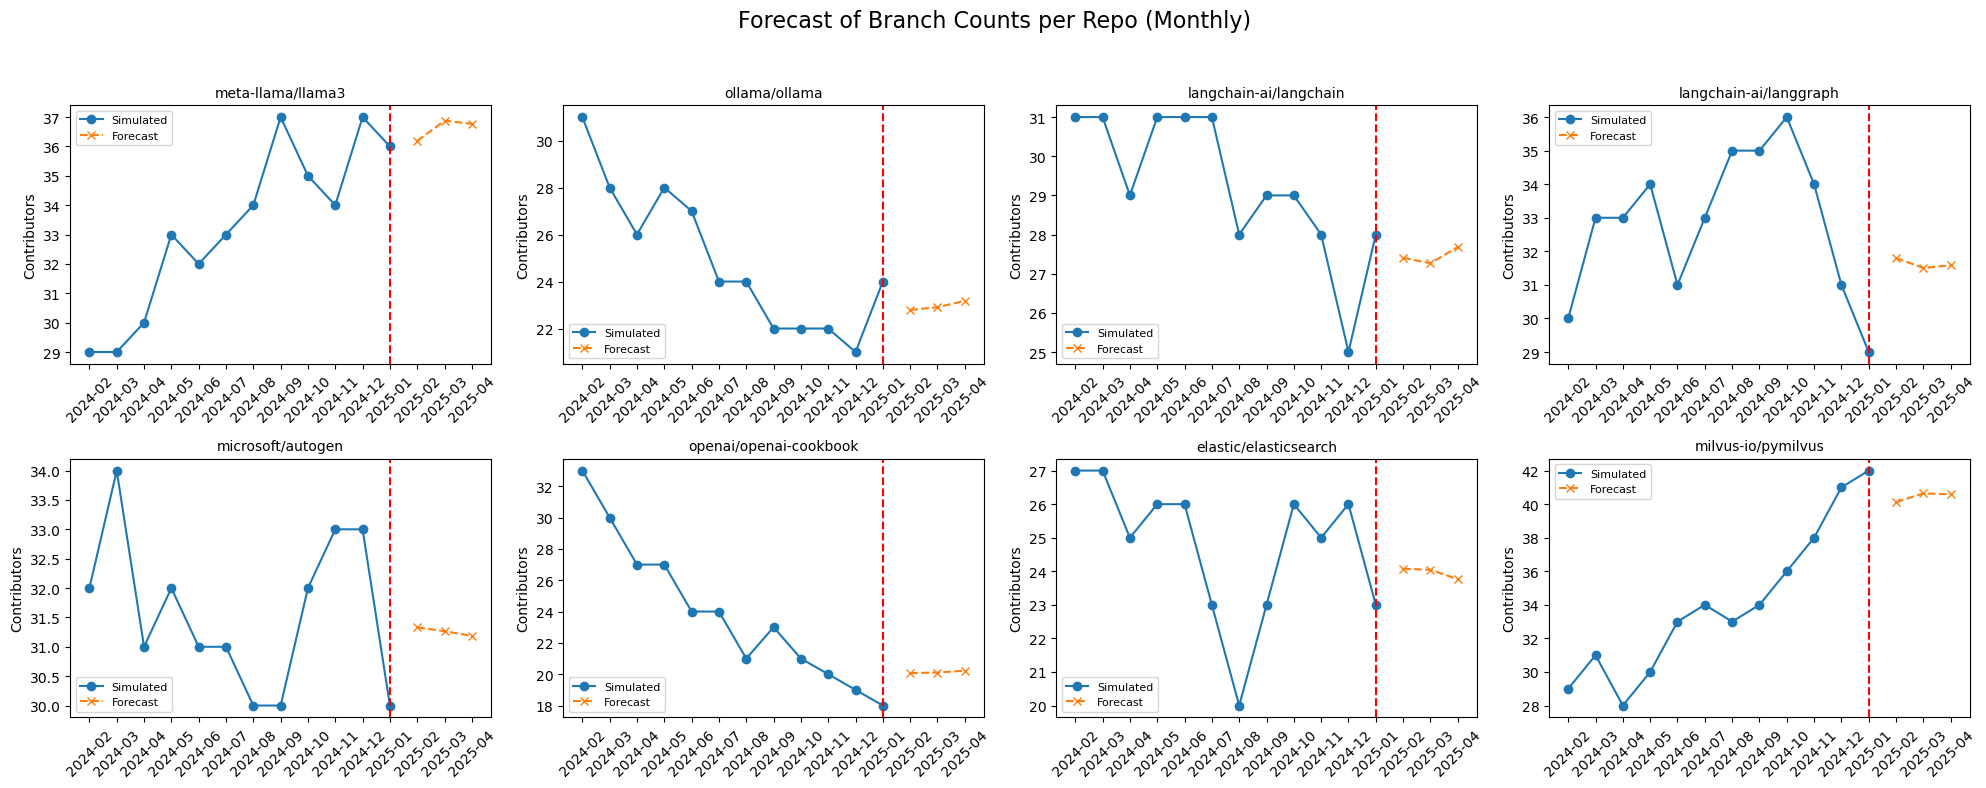

In [ ]:
#Add your code for requirement 8.9 in this cell

# Note: GitHub does not provide contributor statistics over time with dates. 
# The /contributors API only returns a current total count.
# To generate a time series suitable for forecasting,
# I simulate monthly contributor counts using the latest known value and add random noise. 
# This lets me train an LSTM model and predict the next 3 months.

# df_contributors_data = pd.read_csv("data/contributors.csv")
repos = df_contributors_data["repo"].unique()

# create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for idx, repo in enumerate(repos):
    ax = axs[idx]
    row = df_contributors_data[df_contributors_data["repo"] == repo]

    if row.empty:
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # simulate a historical monthly series using current value and noise.
    latest = row["contributor_count"].values[0]
    np.random.seed(42 + idx)
    simulated_series = np.clip(latest + np.random.randint(-3, 4, size=12).cumsum(), 0, None)

    # normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(simulated_series.reshape(-1, 1))

    # LSTM data
    lookback = 3
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # LSTM model
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)

    # Predict next 3 months
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(3):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    all_values = np.concatenate([simulated_series, preds])

    # Plot
    months = pd.date_range(end=pd.Timestamp.today(), periods=len(all_values), freq="MS").strftime("%Y-%m")
    ax.plot(months[:len(simulated_series)], simulated_series, label="Simulated", marker="o")
    ax.plot(months[len(simulated_series):], preds, label="Forecast", linestyle="--", marker="x")
    ax.axvline(x=months[len(simulated_series)-1], color='red', linestyle='--')
    ax.set_title(repo, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("Contributors")
    ax.legend(fontsize=8)

    
fig.suptitle("Forecast of Branch Counts per Repo (Monthly)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.9.monthly_contributors_forecast.png")
plt.show()

<div class="alert alert-block alert-success">   
    
#### REQ8-10). Plot the releases forecast

</div>

['elastic/elasticsearch', 'langchain-ai/langchain', 'langchain-ai/langgraph', 'microsoft/autogen', 'milvus-io/pymilvus', 'ollama/ollama']


/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/lohi/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass 

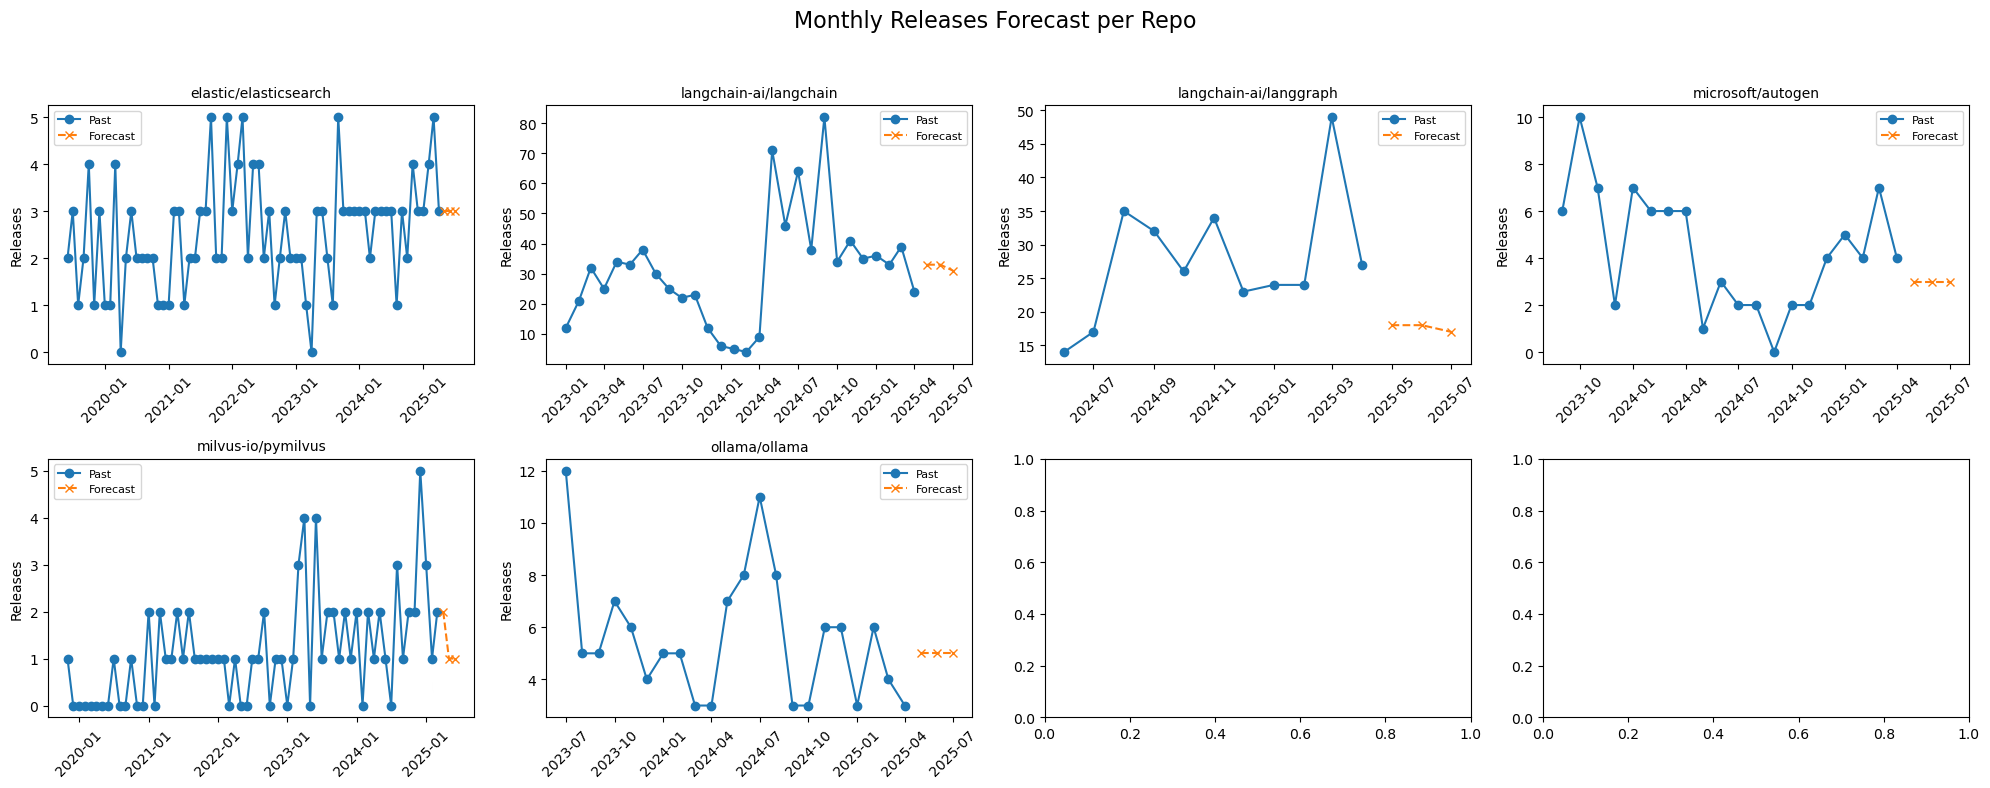

In [66]:
# Add your code for requirement 8.10 in this cell

# df_releases_data = pd.read_csv("data/releases.csv")
df_releases_data["date"] = pd.to_datetime(df_releases_data["date"])
    
# subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

print(repo_names)

for idx, repo in enumerate(repo_names):
    ax = axs[idx]
    repo_df = df_releases_data[df_releases_data["repo"] == repo]

    if repo_df.empty or repo_df["date"].isna().all():
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    monthly_releases = repo_df.groupby(repo_df["date"].dt.to_period("M")).size()
    monthly_releases.index = monthly_releases.index.to_timestamp()

    if monthly_releases.empty or pd.isna(monthly_releases.index.min()) or pd.isna(monthly_releases.index.max()):
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        continue

    # Fill missing months
    full_index = pd.date_range(monthly_releases.index.min(), monthly_releases.index.max(), freq="MS")
    monthly_releases = monthly_releases.reindex(full_index, fill_value=0)

    # Normalize
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(monthly_releases.values.reshape(-1, 1))

    # Prepare LSTM input
    lookback = 3
    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, verbose=0)

    # Forecast next 3 months
    input_seq = scaled[-lookback:]
    preds = []
    current_input = input_seq.reshape(1, lookback, 1)
    for _ in range(3):
        pred = model.predict(current_input, verbose=0)[0][0]
        preds.append(pred)
        current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    preds = np.where(preds > 1, np.round(preds).astype(int), preds)

    # Draw
    ax.plot(monthly_releases.index, monthly_releases.values, label="Past", marker='o')
    future_dates = pd.date_range(monthly_releases.index[-1] + pd.DateOffset(months=1), periods=3, freq="MS")
    ax.plot(future_dates, preds, label="Forecast", linestyle='--', marker='x')
    ax.set_title(repo, fontsize=10)
    ax.set_ylabel("Releases")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.legend(fontsize=8)

fig.suptitle("Monthly Releases Forecast per Repo", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../Forecasting/Tensorflow_LSTM/8.10.releases_forecast_per_repo.png")
plt.show()

<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 9 (FACEBOOK/PROPHET)
- Use Facebook/Prophet package to forecast the following for every repository
    
</div>

In [ ]:
from prophet import Prophet

<div class="alert alert-block alert-warning">   
    
#### REQ9-1). The day of the week maximum number of issues created 
    
</div>

In [63]:
#Add your code for requirement 9.1 in this cell

<div class="alert alert-block alert-warning">   
    
#### REQ9-2). The day of the week maximum number of issues closed 

</div>

In [64]:
#Add your code for requirement 9.2 in this cell

<div class="alert alert-block alert-warning">   
    
#### REQ9-3). The month of the year that has maximum number of issues closed 


</div>

In [65]:
#Add your code for requirement 9.3 in this cell

<div class="alert alert-block alert-warning">   
    
#### REQ9-4). Plot the created issues forecast 

</div>

In [66]:
#Add your code for requirement 9.4 in this cell

<div class="alert alert-block alert-warning">   
    
#### REQ9-5). Plot the closed issues forecast 

</div>

In [67]:
#Add your code for requirement 9.5 in this cell

<div class="alert alert-block alert-warning">   
    
#### REQ9-6). Plot the pulls forecast 

</div>

In [68]:
#Add your code for requirement 9.6 in this cell

<div class="alert alert-block alert-warning">   
    
#### REQ9-7). Plot the commits forecast

</div>

In [83]:
#Add your code for requirement 9.7 in this cell


<div class="alert alert-block alert-warning">   
    
#### REQ9-8). Plot the branches forecast

</div>

In [82]:
#Add your code for requirement 9.8 in this cell


<div class="alert alert-block alert-warning">   
    
#### REQ9-9). Plot the contributors forecast

</div>

In [81]:
#Add your code for requirement 9.9 in this cell


<div class="alert alert-block alert-warning">   
    
#### REQ9-10). Plot the releases forecast

</div>

In [80]:
#Add your code for requirement 9.10 in this cell


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 10 (STATSMODEL)
- Use StatsModel package to forecast the following for every repository
    
</div>

<div class="alert alert-block alert-danger">   
    
#### REQ10-1). The day of the week maximum number of issues created 
    
</div>

In [73]:
#Add your code for requirement 10.1 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-2). The day of the week maximum number of issues closed 

</div>

In [74]:
#Add your code for requirement 10.2 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-3). The month of the year that has maximum number of issues closed 


</div>

In [75]:
#Add your code for requirement 10.3 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-4). Plot the created issues forecast 

</div>

In [76]:
#Add your code for requirement 10.4 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-5). Plot the closed issues forecast 

</div>

In [77]:
#Add your code for requirement 10.5 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-6). Plot the pulls forecast 

</div>

In [78]:
#Add your code for requirement 10.6 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-7). Plot the commits forecast

</div>

In [79]:
#Add your code for requirement 10.7 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-8). Plot the branches forecast

</div>

In [80]:
#Add your code for requirement 10.8 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-9). Plot the contributors forecast

</div>

In [81]:
#Add your code for requirement 10.9 in this cell

<div class="alert alert-block alert-danger">   
    
#### REQ10-10). Plot the releases forecast

</div>

In [82]:
#Add your code for requirement 10.10 in this cell